# Predicting Fashion Categories with Deep Learning

**Task:** Implement an image classifier using a deep learning network, using the Fashion MNIST dataset.

# 0 Import libraries

In [1]:
import timeit

import numpy as np 
import numpy.linalg

import pandas as pd


from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import metrics, preprocessing, feature_selection, linear_model, model_selection
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

from keras.utils import np_utils
from keras.models import Sequential,Model,load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping


import matplotlib.pyplot as plt
import matplotlib.cm as matplotlibcm
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
plt.style.use('default')
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
from IPython.display import display


import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
pio.templates.default = "plotly_white"

# fix random seed for reproducibility
np.random.seed(42)
# Tensorflow seed
tf.random.set_seed(42)

# 1 Load Fashion MNIST dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 2 Exploratory Data Analysis

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

The classes are:

*   0	T-shirt/top
*   1	Trouser
*   2	Pullover
*   3	Dress
*   4	Coat
*   5	Sandal
*   6	Shirt
*   7	Sneaker
*   8	Bag
*   9	Ankle boot






In [3]:
# Create a dictionary for image labels
label_map = {0:"T-shirt/top",
        1:"Trouser",
        2:"Pullover",
        3:"Dress",
        4:"Coat",
        5:"Sandal",
        6:"Shirt",
        7:"Sneaker",
        8:"Bag",
        9:"Boot"}

# Map the labels in y_train
y_train_labels = [*map(label_map.get, y_train)]

# Map the labels in y_test
y_test_labels = [*map(label_map.get, y_test)]

## 2.1 Visualise the dataset

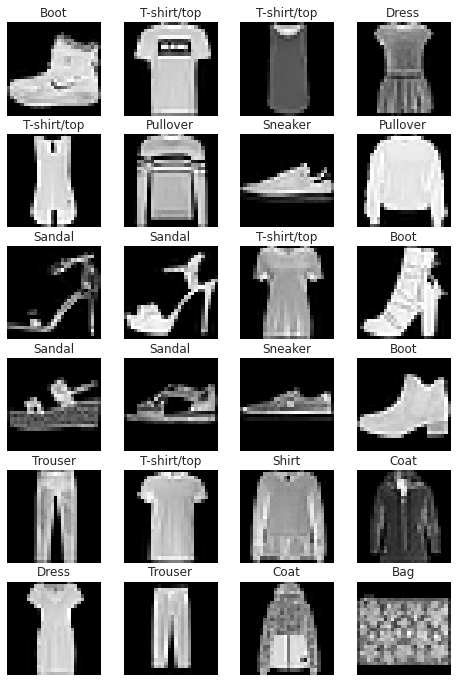

In [4]:
# Visualise first few items in X_train

# Define function to plot images in grid
def plot_grid(data, labels, grid_l, grid_h):
  samples = grid_l*grid_h

  # Plot the grid
  plt.figure(figsize=(grid_l*2, grid_h*2))
  for i in range(samples):
    plt.subplot(grid_h,grid_l,i+1)
    plt.imshow(data[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(labels[i])
  plt.show()



# Set number of plots
data = X_train
labels = y_train_labels
grid_l = 4
grid_h = 6

plot_grid(data, labels, grid_l, grid_h)

## 2.2 Check data format
The following must be performed:
1. **Type conversion to `float32`**, for compatibility with keras and tf.
2. **Normalisation**. Since the image data is from 0 to 255, the data must be rescaled from 0 to 1. This can be done by dividing X_train and X_test by 255.


In [5]:
print("Data type: {}".format(X_train.dtype))
print("Range: "+format(np.min(X_train))+" to "+format(np.max(X_train)))

Data type: uint8
Range: 0 to 255


# 3 Data Processing

In [6]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train/255
X_test = X_test/255

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

# 4 Modelling
Our approach:
1. Use predefined models such as ResNet50 and Inception V3 to gauge the benchmark.
2. Next, we explore bespoke CNN models, experimenting with different architectures first, then hyperparameter tuning. Architectural changes impacted accuracy the most. We followed the sequence below:

> 1. **Tuning number of layers.** We tried removing layers to make the model parsimonious, but accuracy became lower.
> 2. **Tuning type of layers.** We tried `MaxPooling2D` and `BatchNormalization`. Both were comparable in terms of accuracy, but `BatchNormalization` had more parameters.
> 3. **Different activation functions.** Using `tanh` instead of `relu` in the Conv2D layers improved accuracy.
> 4. **Different optimizers.**
We explored Adam and RMSprop optimizers since both perform well for CNN models. Adam yielded a higher accuracy.
> 5. **Tuning batch size and learning rate.** Using RandomizedSearchCV. 

## 4.1 Define functions for evaluating classification model

In [7]:
# Function to plot loss and accuracy plots

def loss_acc_plots(h_callback):
  plt.figure(figsize=(10, 10))

  # Plot training and validation loss
  plt.subplot(2, 2, 1)
  plt.plot(h_callback.history['loss'], label='Loss', color = 'grey')
  plt.plot(h_callback.history['val_loss'], label='Validation Loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title('Loss function')

  # Plot training and validation accuracy
  plt.subplot(2, 2, 2)
  plt.plot(h_callback.history['accuracy'], label='Accuracy', color = 'grey')
  plt.plot(h_callback.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

#=========================================================================
# Function to print classification report and confusion matrix

def classification_summary(y_pred,y_test, target_names):
  y_pred_array = np.argmax(y_pred, axis=1)
  y_test_array = np.argmax(y_test, axis=1)

  print("=== Classification Report ===" ,end='\n\n')
  print(metrics.classification_report(y_test_array, y_pred_array, target_names=target_names))

  # Confusion matrix
  fig = plt.figure(figsize=(10,9))
  ax= plt.subplot()
  cm = metrics.confusion_matrix(y_test_array, y_pred_array)
  sns.heatmap(cm, annot=True, cmap="BuPu", fmt='g')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted label') 
  ax.set_ylabel('True label')
  ax.xaxis.set_ticklabels(list(target_names)); ax.yaxis.set_ticklabels(list(target_names));
  plt.show()

#=========================================================================
# Define function to create feature maps
# Adapted from: https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c

def plot_featuremap(model, input):
  # Extract layer names for feature map title
  layer_names = [layer.name for layer in model.layers]
  layer_outputs = [layer.output for layer in model.layers]

  # Create feature maps using Model() as a wrapper
  feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
  feature_maps = feature_map_model.predict(input)

  # Check the shape of the layers
  for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

  # Iterate through the layers
  for layer_name, feature_map in zip(layer_names, feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) == 4: # Number of dimensions in a feature map of a layer
      
      # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
      
      # Tile the images
      display_grid = np.zeros((size, size * n_features))
      
      # Some processing to make the features look better
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        # Tile each filter into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x

  # Display the grid
      scale = 20. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( layer_name )
      plt.grid  ( False )
      plt.imshow( display_grid, aspect='auto', cmap='viridis' )


## 4.2 Build a CNN model

Based on the prediction task, we can narrow down the following:
1. Use **CNN**, since it has been known to perform well for image classification tasks.
2. Use **categorical cross-entropy** for the loss function, since the task is a multi-class classification problem.
3. Use **softmax activation** in the final layer, since the task is a multi-class classification problem.
4. **ReLu** activation is preferred in CNN since it is less susceptible to vanishing gradients that prevent deep networks from learning effectively. However, we can also explore tuning this parameter.

### 4.2.1 ResNet50
First, we try ResNet50 - a widely used model - as an industry benchmark. ResNet50 has relatively high accuracy and is less operationally-intensive.

![Alt text](https://asset-pdf.scinapse.io/prod/2419597278/figures/figure-2.jpg)

Source: [An Analysis of Deep Neural Network Models for Practical Applications, 2016](https://www.scinapse.io/papers/2419597278)

In [12]:
# Since ResNet50 requires the data shape to be (32,32,3), we create new train2 and test2 datasets for ResNet50.
# So that we preseve the earlier train and test datasets as shape(28,28,1)

(X_train2, y_train2), (X_test2, y_test2) = tf.keras.datasets.fashion_mnist.load_data()

# Expand new axis, channel axis 
X_train2 = np.expand_dims(X_train2, axis=-1)
X_test2 = np.expand_dims(X_test2, axis=-1)

# Change to 3 channels
X_train2 = np.repeat(X_train2, 3, axis=-1)
X_test2 = np.repeat(X_test2, 3, axis=-1)

# Normalize inputs from 0-255 to 0-1
X_train2 = X_train2.astype('float32') / 255
X_test2 = X_test2.astype('float32') / 255

# Resize the input shape from 28 to 32
X_train2 = tf.image.resize(X_train2, [32,32])
X_test2 = tf.image.resize(X_test2, [32,32])

# One hot encode outputs
y_train2 = to_categorical(y_train2, num_classes=10)
y_test2 = to_categorical(y_test2, num_classes=10)

print(X_train2.shape, y_train2.shape)

(60000, 32, 32, 3) (60000, 10)


Epoch 1/20
300/300 - 69s - loss: 0.3797 - accuracy: 0.8720 - val_loss: 3.3015 - val_accuracy: 0.1393 - 69s/epoch - 230ms/step
Epoch 2/20
300/300 - 61s - loss: 0.2303 - accuracy: 0.9175 - val_loss: 1.5204 - val_accuracy: 0.5174 - 61s/epoch - 203ms/step
Epoch 3/20
300/300 - 61s - loss: 0.1947 - accuracy: 0.9282 - val_loss: 0.6049 - val_accuracy: 0.8212 - 61s/epoch - 203ms/step
Epoch 4/20
300/300 - 61s - loss: 0.1768 - accuracy: 0.9348 - val_loss: 0.2991 - val_accuracy: 0.8993 - 61s/epoch - 203ms/step
Epoch 5/20
300/300 - 59s - loss: 0.1642 - accuracy: 0.9406 - val_loss: 0.3597 - val_accuracy: 0.8809 - 59s/epoch - 198ms/step
Epoch 6/20
300/300 - 59s - loss: 0.1491 - accuracy: 0.9458 - val_loss: 0.3669 - val_accuracy: 0.8807 - 59s/epoch - 198ms/step
Epoch 7/20
300/300 - 61s - loss: 0.1346 - accuracy: 0.9504 - val_loss: 0.2824 - val_accuracy: 0.9103 - 61s/epoch - 202ms/step
Epoch 8/20
300/300 - 59s - loss: 0.1228 - accuracy: 0.9548 - val_loss: 0.2980 - val_accuracy: 0.9109 - 59s/epoch - 198

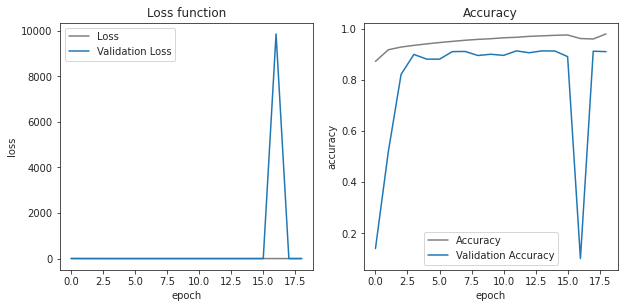

=== Classification Report ===

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.80      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.86      0.83      0.85      1000
       Dress       0.91      0.92      0.92      1000
        Coat       0.89      0.81      0.85      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.67      0.85      0.75      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.98      0.99      0.99      1000
        Boot       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



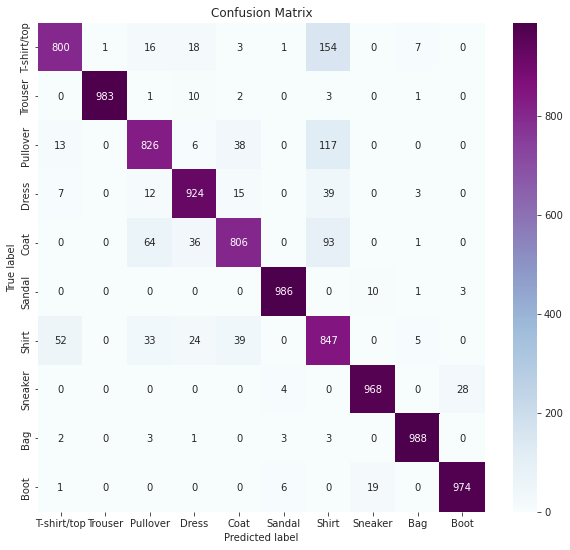

In [15]:
# Start timer
start = timeit.default_timer()

# Basic ResNet50
base_model = tf.keras.applications.resnet50.ResNet50(weights= 'imagenet', pooling='avg', include_top=False, input_shape= (32,32,3))
x = base_model.output

# Output layer
predictions = Dense(10, activation= 'softmax')(x)

# This creates a model that includes the base model and output later
model = Model(inputs = base_model.input, outputs = predictions)

# Compile the model
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to monitor validation accuracy with early stopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)

# Save the best model
model_checkpoint = ModelCheckpoint('bestmodel.hdf5', save_best_only = True)

# Fit the model
h_callback2 = model.fit(X_train2, y_train2, validation_data=(X_test2, y_test2),epochs=20, batch_size=200, verbose=2,
                       callbacks=[monitor_val_acc,model_checkpoint])


# Stop timer
stop = timeit.default_timer()

# Final evaluation of the model
scores = model.evaluate(X_test2, y_test2)



# Specify variables
y_pred2 = model.predict(X_test2)
target_names = label_map.values()



# Model evaluation

print("===============================================")
# Print model summary
model.summary()
resnet50_acc = scores[1]*100
resnet50_runtime = stop - start
print("ResNet50 accuracy: %.2f%%" % resnet50_acc)
print('Training time (s): ', resnet50_runtime)

# Print evaluation report
loss_acc_plots(h_callback2)
classification_summary(y_pred2,y_test2, target_names)

# Print feature maps
#input = X_test2[1].reshape(1,32,32,3)
#plot_featuremap(model, input)

### 4.2.2 Inception v3
Next, we try Inception v3 as an industry benchmark. Inception v3 performs better than ResNet50 in accurarcy but is more operationally-intensive.

In [16]:
# Since Inception v3 requires the data shape to be (75,75,3), we create new train3 and test3 datasets for Inception v3.
# So that we preseve the earlier train and test datasets' shapes.

(X_train3, y_train3), (X_test3, y_test3) = tf.keras.datasets.fashion_mnist.load_data()

# Expand new axis, channel axis 
X_train3 = np.expand_dims(X_train3, axis=-1)
X_test3 = np.expand_dims(X_test3, axis=-1)

# Change to 3 channels
X_train3 = np.repeat(X_train3, 3, axis=-1)
X_test3 = np.repeat(X_test3, 3, axis=-1)

# Normalize inputs from 0-255 to 0-1
X_train3 = X_train3.astype('float32') / 255
X_test3 = X_test3.astype('float32') / 255

# Resize the input shape from 28 to 75
X_train3 = tf.image.resize(X_train3, [75,75])
X_test3 = tf.image.resize(X_test3, [75,75])

# One hot encode outputs
y_train3 = to_categorical(y_train3, num_classes=10)
y_test3 = to_categorical(y_test3, num_classes=10)

print(X_train3.shape, y_train3.shape)

(60000, 75, 75, 3) (60000, 10)


87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/20
300/300 - 131s - loss: 0.3260 - accuracy: 0.8865 - val_loss: 0.3115 - val_accuracy: 0.9147 - 131s/epoch - 436ms/step
Epoch 2/20
300/300 - 115s - loss: 0.1872 - accuracy: 0.9341 - val_loss: 0.2566 - val_accuracy: 0.9190 - 115s/epoch - 384ms/step
Epoch 3/20
300/300 - 114s - loss: 0.1533 - accuracy: 0.9451 - val_loss: 0.2820 - val_accuracy: 0.9058 - 114s/epoch - 381ms/step
Epoch 4/20
300/300 - 115s - loss: 0.1303 - accuracy: 0.9534 - val_loss: 0.2389 - val_accuracy: 0.9253 - 115s/epoch - 385ms/step
Epoch 5/20
300/300 - 116s - loss: 0.1148 - accuracy: 0.9595 - val_loss: 0.2385 - val_accuracy: 0.9204 - 116s/epoch - 385ms/step
Epoch 6/20
300/300 - 114s - loss: 0.1009 - accuracy: 0.9645 - val_loss: 0.2594 - val_accuracy: 0.9211 - 114s/epoch - 378ms/step
Epoch 7/20
300/300 - 113s - loss: 0.0877 - accuracy: 0.9693 - val_loss: 0.3375 - val_accuracy: 0.9014 - 113s/epoch - 378ms/step
Epoch 8/20
300/300 - 115s - loss: 0.074

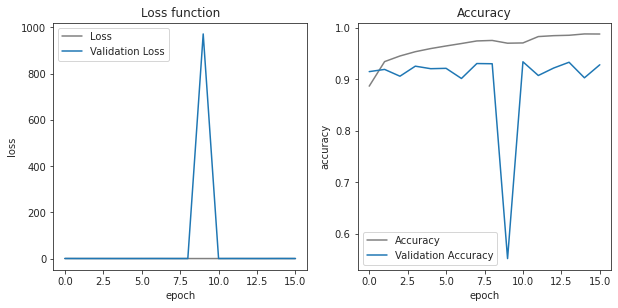

=== Classification Report ===

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.86      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.86      0.90      0.88      1000
       Dress       0.92      0.93      0.93      1000
        Coat       0.94      0.82      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.75      0.86      0.80      1000
     Sneaker       0.98      0.98      0.98      1000
         Bag       1.00      0.98      0.99      1000
        Boot       0.98      0.98      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



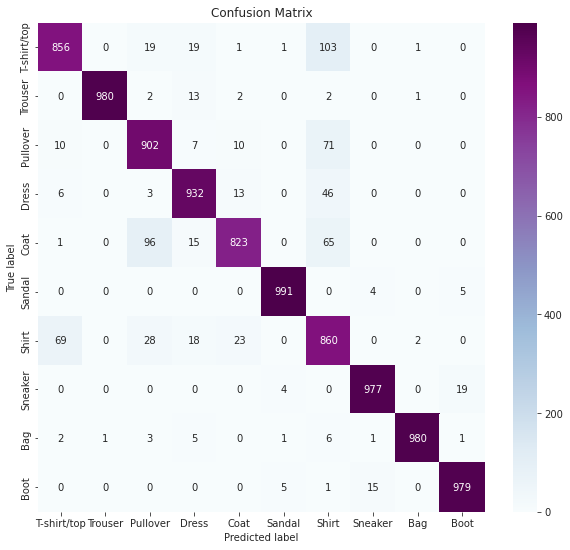

In [17]:
# Start timer
start = timeit.default_timer()

# Basic InceptionV3
base_model = tf.keras.applications.InceptionV3(weights='imagenet', pooling='avg', include_top=False, input_shape= (75,75,3))
x = base_model.output
#x = GlobalAveragePooling2D()(x)

# Output layer
predictions = Dense(10, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to monitor validation accuracy with early stopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)

# Save the best model
model_checkpoint = ModelCheckpoint('bestmodel.hdf5', save_best_only = True)

# Fit the model
h_callback3 = model.fit(X_train3, y_train3, validation_data=(X_test3, y_test3),epochs=20, batch_size=200, verbose=2,
                       callbacks=[monitor_val_acc,model_checkpoint])


# Stop timer
stop = timeit.default_timer()

# Final evaluation of the model
scores = model.evaluate(X_test3, y_test3)



# Specify variables
y_pred3 = model.predict(X_test3)
target_names = label_map.values()


print("===============================================")
# Print model summary
model.summary()
inceptionv3_acc = scores[1]*100
inceptionv3_runtime = stop - start
print("Inception v3 accuracy: %.2f%%" % inceptionv3_acc)
print('Training time (s): ', inceptionv3_runtime)

# Print evaluation report
loss_acc_plots(h_callback3)
classification_summary(y_pred3,y_test3, target_names)

# Print feature maps
#input = X_test3[1].reshape(1,75,75,3)
#plot_featuremap(model, input)

### 4.2.3 CNN1
We try a bespoke CNN model to see if its performance is comparable the "industry-grade" models.

**Findings:**
1. CNN1's accuracy was comparable with ResNet50, but had s significantly shorter runtime.
2. From the feature maps, we notice **much of the image information is lost at the second `Conv2D` layer**.

Epoch 1/20
300/300 - 13s - loss: 0.7248 - accuracy: 0.7337 - val_loss: 0.4829 - val_accuracy: 0.8276 - 13s/epoch - 45ms/step
Epoch 2/20
300/300 - 3s - loss: 0.4670 - accuracy: 0.8308 - val_loss: 0.4096 - val_accuracy: 0.8551 - 3s/epoch - 11ms/step
Epoch 3/20
300/300 - 4s - loss: 0.4048 - accuracy: 0.8543 - val_loss: 0.3728 - val_accuracy: 0.8647 - 4s/epoch - 14ms/step
Epoch 4/20
300/300 - 4s - loss: 0.3686 - accuracy: 0.8669 - val_loss: 0.3506 - val_accuracy: 0.8755 - 4s/epoch - 14ms/step
Epoch 5/20
300/300 - 4s - loss: 0.3432 - accuracy: 0.8746 - val_loss: 0.3369 - val_accuracy: 0.8777 - 4s/epoch - 14ms/step
Epoch 6/20
300/300 - 4s - loss: 0.3240 - accuracy: 0.8821 - val_loss: 0.3360 - val_accuracy: 0.8760 - 4s/epoch - 13ms/step
Epoch 7/20
300/300 - 4s - loss: 0.3071 - accuracy: 0.8883 - val_loss: 0.3072 - val_accuracy: 0.8880 - 4s/epoch - 15ms/step
Epoch 8/20
300/300 - 4s - loss: 0.2968 - accuracy: 0.8914 - val_loss: 0.3069 - val_accuracy: 0.8876 - 4s/epoch - 14ms/step
Epoch 9/20
300

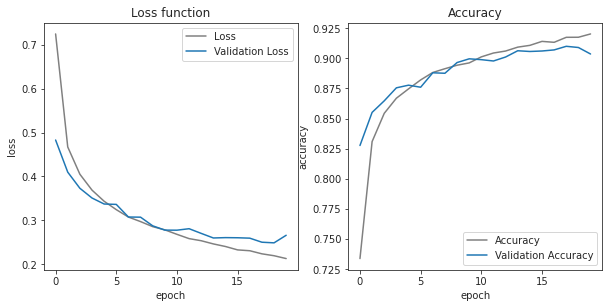

=== Classification Report ===

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.83      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.93      0.76      0.84      1000
       Dress       0.89      0.94      0.91      1000
        Coat       0.85      0.85      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.67      0.79      0.73      1000
     Sneaker       0.97      0.94      0.95      1000
         Bag       0.98      0.99      0.98      1000
        Boot       0.94      0.98      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



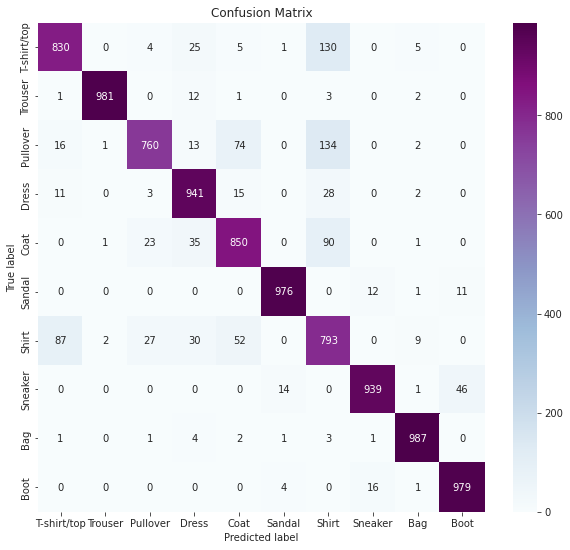

The shape of the conv2d is =======>> (1, 24, 24, 30)
The shape of the max_pooling2d is =======>> (1, 12, 12, 30)
The shape of the conv2d_1 is =======>> (1, 10, 10, 15)
The shape of the max_pooling2d_1 is =======>> (1, 5, 5, 15)
The shape of the dropout is =======>> (1, 5, 5, 15)
The shape of the flatten is =======>> (1, 375)
The shape of the dense is =======>> (1, 128)
The shape of the dense_1 is =======>> (1, 50)
The shape of the dense_2 is =======>> (1, 10)
(1, 24, 24, 30)
(1, 12, 12, 30)
(1, 10, 10, 15)
(1, 5, 5, 15)
(1, 5, 5, 15)
(1, 375)
(1, 128)
(1, 50)
(1, 10)


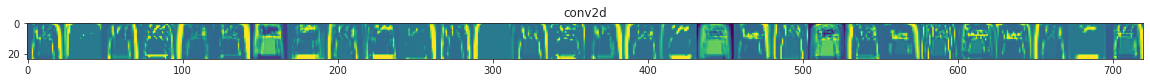

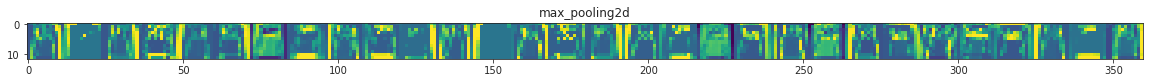

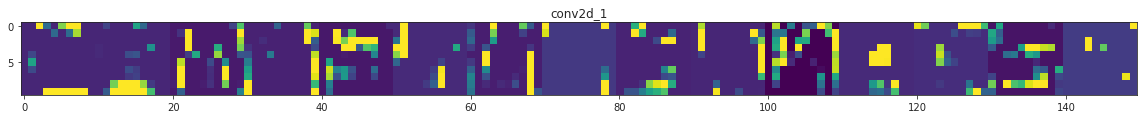

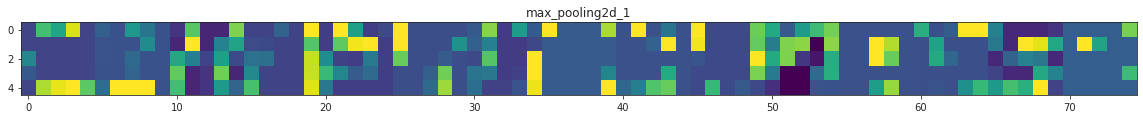

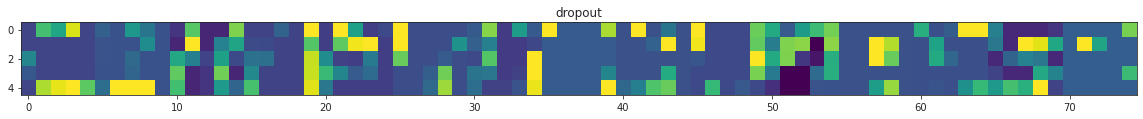

In [8]:
# Start timer
start = timeit.default_timer()

# Build the model
model = Sequential()
model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a callback to monitor validation accuracy with early stopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)

# Save the best model
model_checkpoint = ModelCheckpoint('bestmodel.hdf5', save_best_only = True)

# Fit the model
h_callback = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=200, verbose=2,
                       callbacks=[monitor_val_acc,model_checkpoint])


# Stop timer
stop = timeit.default_timer()

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)



# Specify variables
y_pred = model.predict(X_test)
target_names = label_map.values()

# Model evaluation

print("===============================================")
# Print model summary
model.summary()
cnn1_acc = scores[1]*100
cnn1_runtime = stop - start
print("CNN1 Accuracy: %.2f%%" % cnn1_acc)
print('Training time (s): ', cnn1_runtime)

# Print evaluation report
loss_acc_plots(h_callback)
classification_summary(y_pred,y_test, target_names)

# Print feature maps
input = X_test[1].reshape(1,28,28,1)
plot_featuremap(model, input)

### 4.2.4 CNN2
Based on CNN1, but with `BatchNormalization` instead of `MaxPooling2D`.
`BatchNormalization` improves the learning speed of Neural Networks and provides regularization, avoiding overfitting.

**Findings:**
1. Validation accuracy plateaued fairly quickly.
2. Accuracy was comparable with CNN1.
3. From the feature maps, we notice **some fo the filters in the first `Conv2D` layer did not manage to pick out the item's outline**.

Epoch 1/20
300/300 - 5s - loss: 0.4292 - accuracy: 0.8463 - val_loss: 1.6440 - val_accuracy: 0.5087 - 5s/epoch - 18ms/step
Epoch 2/20
300/300 - 4s - loss: 0.2716 - accuracy: 0.8985 - val_loss: 0.3571 - val_accuracy: 0.8694 - 4s/epoch - 14ms/step
Epoch 3/20
300/300 - 4s - loss: 0.2113 - accuracy: 0.9202 - val_loss: 0.2852 - val_accuracy: 0.8954 - 4s/epoch - 14ms/step
Epoch 4/20
300/300 - 4s - loss: 0.1743 - accuracy: 0.9346 - val_loss: 0.3336 - val_accuracy: 0.8857 - 4s/epoch - 14ms/step
Epoch 5/20
300/300 - 4s - loss: 0.1468 - accuracy: 0.9450 - val_loss: 0.2821 - val_accuracy: 0.9040 - 4s/epoch - 14ms/step
Epoch 6/20
300/300 - 4s - loss: 0.1203 - accuracy: 0.9547 - val_loss: 0.2923 - val_accuracy: 0.9024 - 4s/epoch - 14ms/step
Epoch 7/20
300/300 - 4s - loss: 0.1076 - accuracy: 0.9598 - val_loss: 0.3053 - val_accuracy: 0.9088 - 4s/epoch - 14ms/step
Epoch 8/20
300/300 - 6s - loss: 0.0863 - accuracy: 0.9683 - val_loss: 0.3577 - val_accuracy: 0.9002 - 6s/epoch - 19ms/step
Epoch 9/20
300/3

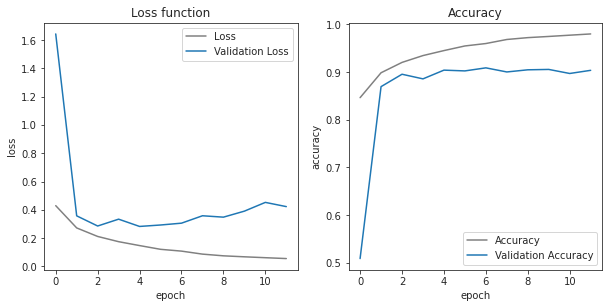

=== Classification Report ===

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.84      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.82      0.87      0.84      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.86      0.83      0.84      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.72      0.74      0.73      1000
     Sneaker       0.96      0.95      0.96      1000
         Bag       0.98      0.97      0.98      1000
        Boot       0.95      0.98      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



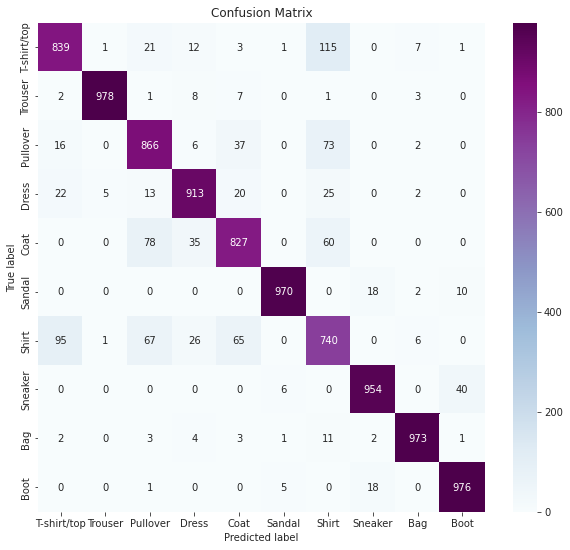

The shape of the conv2d_2 is =======>> (1, 24, 24, 30)
The shape of the batch_normalization is =======>> (1, 24, 24, 30)
The shape of the conv2d_3 is =======>> (1, 22, 22, 15)
The shape of the batch_normalization_1 is =======>> (1, 22, 22, 15)
The shape of the dropout_1 is =======>> (1, 22, 22, 15)
The shape of the flatten_1 is =======>> (1, 7260)
The shape of the dense_3 is =======>> (1, 128)
The shape of the dense_4 is =======>> (1, 50)
The shape of the dense_5 is =======>> (1, 10)
(1, 24, 24, 30)
(1, 24, 24, 30)
(1, 22, 22, 15)
(1, 22, 22, 15)
(1, 22, 22, 15)
(1, 7260)
(1, 128)
(1, 50)
(1, 10)


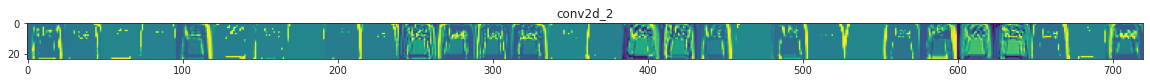

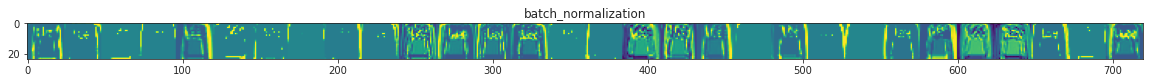

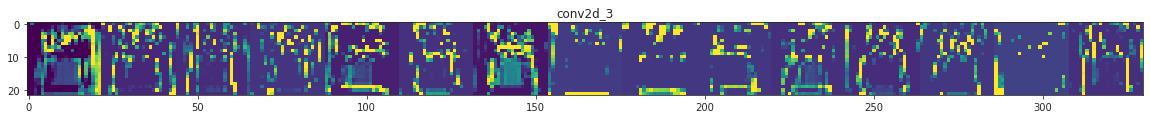

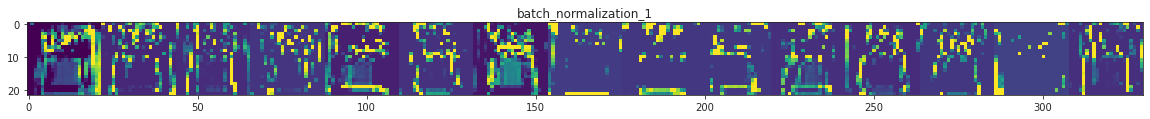

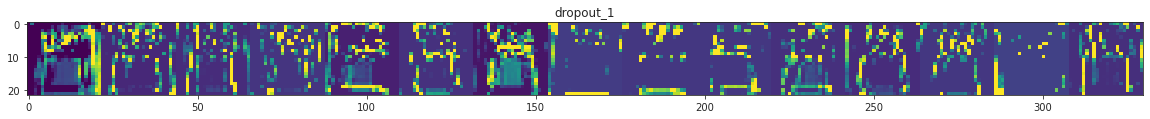

In [9]:
# Start timer
start = timeit.default_timer()

# build the model
# We also tried to use kernel_initializer='normal' in the Conv2D and Dense layers, but accuracy was worse
model = Sequential()
model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a callback to monitor validation accuracy with early stopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)

# Save the best model
model_checkpoint = ModelCheckpoint('bestmodel.hdf5', save_best_only = True)

# Fit the model
h_callback = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=200, verbose=2,
                       callbacks=[monitor_val_acc,model_checkpoint])


# Stop timer
stop = timeit.default_timer()

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)



# Specify variables
y_pred = model.predict(X_test)
target_names = label_map.values()

# Model evaluation

print("===============================================")
# Print model summary
model.summary()
cnn2_acc = scores[1]*100
cnn2_runtime = stop - start
print("CNN2 Accuracy: %.2f%%" % cnn2_acc)
print('Training time (s): ', cnn2_runtime)

# Print evaluation report
loss_acc_plots(h_callback)
classification_summary(y_pred,y_test, target_names)

# Print feature maps
input = X_test[1].reshape(1,28,28,1)
plot_featuremap(model, input)

### 4.2.5 CNN3
Based on CNN1, but with more filters.

**Findings:**
1. Accuracy was marginally better than CNN1 and CNN2.
2. From the feature maps, we notice CNN3's first two layers managed to pick out the outline better than CNN2, but **some image information is lost at the second `Conv2D` layer**.

Epoch 1/20
300/300 - 4s - loss: 0.6150 - accuracy: 0.7789 - val_loss: 0.4342 - val_accuracy: 0.8497 - 4s/epoch - 15ms/step
Epoch 2/20
300/300 - 3s - loss: 0.3978 - accuracy: 0.8573 - val_loss: 0.3680 - val_accuracy: 0.8667 - 3s/epoch - 11ms/step
Epoch 3/20
300/300 - 3s - loss: 0.3384 - accuracy: 0.8796 - val_loss: 0.3279 - val_accuracy: 0.8825 - 3s/epoch - 11ms/step
Epoch 4/20
300/300 - 3s - loss: 0.3079 - accuracy: 0.8884 - val_loss: 0.2989 - val_accuracy: 0.8924 - 3s/epoch - 11ms/step
Epoch 5/20
300/300 - 3s - loss: 0.2842 - accuracy: 0.8960 - val_loss: 0.2883 - val_accuracy: 0.8963 - 3s/epoch - 11ms/step
Epoch 6/20
300/300 - 3s - loss: 0.2648 - accuracy: 0.9032 - val_loss: 0.2784 - val_accuracy: 0.8998 - 3s/epoch - 11ms/step
Epoch 7/20
300/300 - 3s - loss: 0.2500 - accuracy: 0.9078 - val_loss: 0.2635 - val_accuracy: 0.9041 - 3s/epoch - 11ms/step
Epoch 8/20
300/300 - 3s - loss: 0.2344 - accuracy: 0.9126 - val_loss: 0.2648 - val_accuracy: 0.9058 - 3s/epoch - 11ms/step
Epoch 9/20
300/3

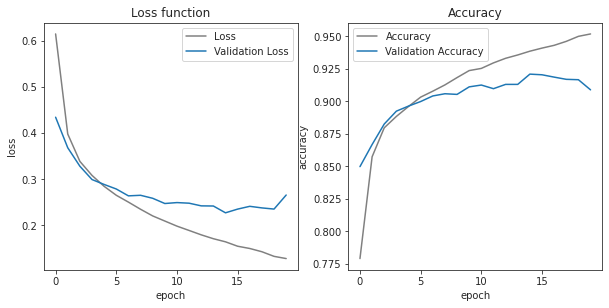

=== Classification Report ===

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.81      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.92      0.78      0.85      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.86      0.88      0.87      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.67      0.83      0.74      1000
     Sneaker       0.98      0.94      0.96      1000
         Bag       0.98      0.98      0.98      1000
        Boot       0.93      0.99      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



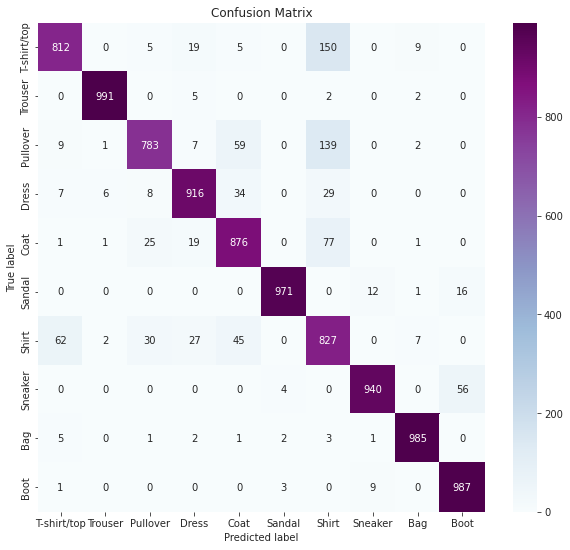

The shape of the conv2d_4 is =======>> (1, 24, 24, 32)
The shape of the max_pooling2d_2 is =======>> (1, 12, 12, 32)
The shape of the conv2d_5 is =======>> (1, 10, 10, 64)
The shape of the max_pooling2d_3 is =======>> (1, 5, 5, 64)
The shape of the dropout_2 is =======>> (1, 5, 5, 64)
The shape of the flatten_2 is =======>> (1, 1600)
The shape of the dense_6 is =======>> (1, 128)
The shape of the dense_7 is =======>> (1, 50)
The shape of the dense_8 is =======>> (1, 10)
(1, 24, 24, 32)
(1, 12, 12, 32)
(1, 10, 10, 64)
(1, 5, 5, 64)
(1, 5, 5, 64)
(1, 1600)
(1, 128)
(1, 50)
(1, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


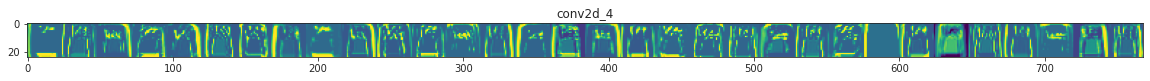

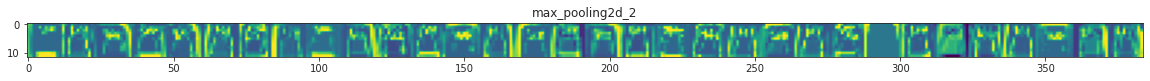

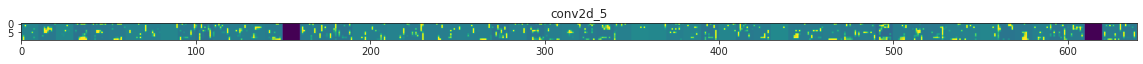

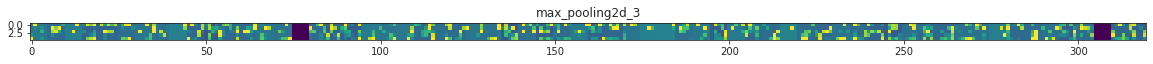

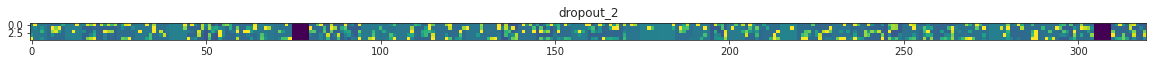

In [10]:
# Start timer
start = timeit.default_timer()

# Build the model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a callback to monitor validation accuracy with early stopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)

# Save the best model
model_checkpoint = ModelCheckpoint('bestmodel.hdf5', save_best_only = True)

# Fit the model
h_callback = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=200, verbose=2,
                       callbacks=[monitor_val_acc,model_checkpoint])


# Stop timer
stop = timeit.default_timer()

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)



# Specify variables
y_pred = model.predict(X_test)
target_names = label_map.values()

# Model evaluation

print("===============================================")
# Print model summary
model.summary()
cnn3_acc = scores[1]*100
cnn3_runtime = stop - start
print("CNN3 Accuracy: %.2f%%" % cnn3_acc)
print('Training time (s): ', cnn3_runtime)

# Print evaluation report
loss_acc_plots(h_callback)
classification_summary(y_pred,y_test, target_names)

# Print feature maps
input = X_test[1].reshape(1,28,28,1)
plot_featuremap(model, input)

### 4.2.6 CNN4
Based on CNN3, but
 
*   Using `activation='tanh'` in Conv2D layers
*   less 1 Dense layer
*   `padding='same'` in Conv2D and MaxPooling2D layers

**Findings:**
1. Accuracy was better than ResNet50, CNN1, CNN2 and CNN3.
2. From the feature maps, the image outline is still discernable at the `Dropout` layer.

Epoch 1/20
300/300 - 4s - loss: 0.5751 - accuracy: 0.7939 - val_loss: 0.4131 - val_accuracy: 0.8505 - 4s/epoch - 14ms/step
Epoch 2/20
300/300 - 3s - loss: 0.3687 - accuracy: 0.8677 - val_loss: 0.3482 - val_accuracy: 0.8706 - 3s/epoch - 11ms/step
Epoch 3/20
300/300 - 3s - loss: 0.3182 - accuracy: 0.8853 - val_loss: 0.3108 - val_accuracy: 0.8876 - 3s/epoch - 11ms/step
Epoch 4/20
300/300 - 3s - loss: 0.2870 - accuracy: 0.8957 - val_loss: 0.2936 - val_accuracy: 0.8931 - 3s/epoch - 11ms/step
Epoch 5/20
300/300 - 3s - loss: 0.2652 - accuracy: 0.9037 - val_loss: 0.2843 - val_accuracy: 0.8970 - 3s/epoch - 11ms/step
Epoch 6/20
300/300 - 3s - loss: 0.2473 - accuracy: 0.9090 - val_loss: 0.2784 - val_accuracy: 0.8940 - 3s/epoch - 11ms/step
Epoch 7/20
300/300 - 3s - loss: 0.2296 - accuracy: 0.9150 - val_loss: 0.2607 - val_accuracy: 0.9038 - 3s/epoch - 11ms/step
Epoch 8/20
300/300 - 3s - loss: 0.2154 - accuracy: 0.9203 - val_loss: 0.2567 - val_accuracy: 0.9059 - 3s/epoch - 11ms/step
Epoch 9/20
300/3

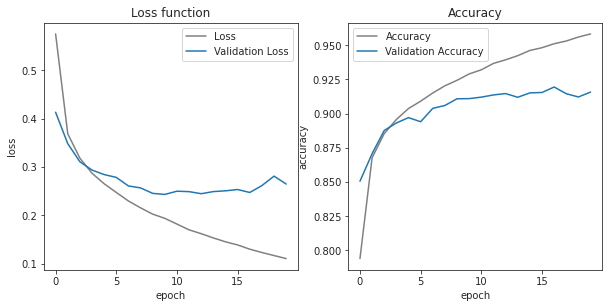

=== Classification Report ===

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.87      0.87      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.90      0.81      0.86      1000
       Dress       0.93      0.92      0.92      1000
        Coat       0.82      0.90      0.86      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.75      0.76      0.75      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.98      0.99      0.98      1000
        Boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



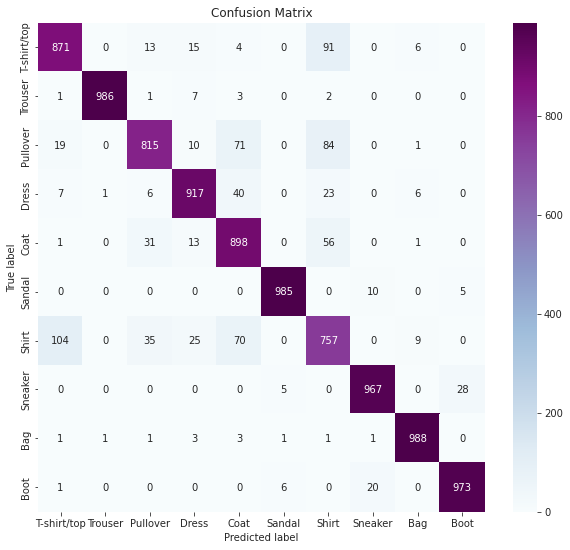

The shape of the conv2d_104 is =======>> (1, 28, 28, 32)
The shape of the max_pooling2d_12 is =======>> (1, 14, 14, 32)
The shape of the conv2d_105 is =======>> (1, 14, 14, 64)
The shape of the max_pooling2d_13 is =======>> (1, 7, 7, 64)
The shape of the dropout_5 is =======>> (1, 7, 7, 64)
The shape of the flatten_5 is =======>> (1, 3136)
The shape of the dense_17 is =======>> (1, 50)
The shape of the dense_18 is =======>> (1, 10)
(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 14, 14, 64)
(1, 7, 7, 64)
(1, 7, 7, 64)
(1, 3136)
(1, 50)
(1, 10)


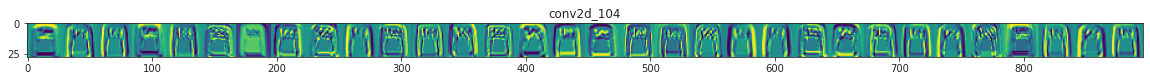

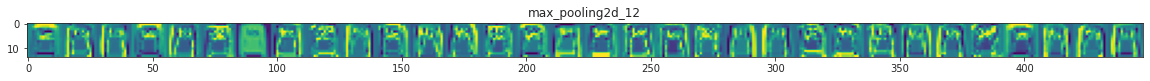

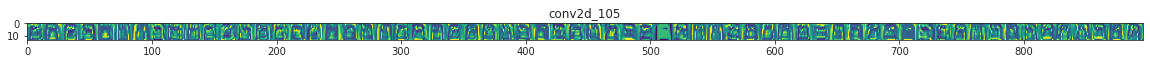

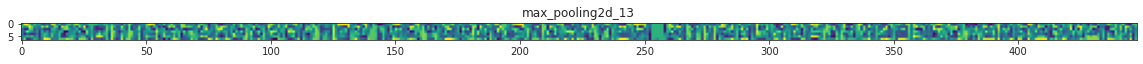

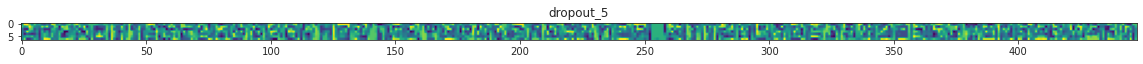

In [19]:
# Start timer
start = timeit.default_timer()

# Build the model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='tanh',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='tanh',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a callback to monitor validation accuracy with early stopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)

# Save the best model
model_checkpoint = ModelCheckpoint('bestmodel.hdf5', save_best_only = True)

# Fit the model
h_callback = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=200, verbose=2,
                       callbacks=[monitor_val_acc,model_checkpoint])


# Stop timer
stop = timeit.default_timer()

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)



# Specify variables
y_pred = model.predict(X_test)
target_names = label_map.values()

# Model evaluation

print("===============================================")
# Print model summary
model.summary()
cnn4_acc = scores[1]*100
cnn4_runtime = stop - start
print("CNN4 Accuracy: %.2f%%" % cnn4_acc)
print('Training time (s): ', cnn4_runtime)

# Print evaluation report
loss_acc_plots(h_callback)
classification_summary(y_pred,y_test, target_names)

# Print feature maps
input = X_test[1].reshape(1,28,28,1)
plot_featuremap(model, input)

### 4.2.7 CNN5
Based on CNN4 with hyperparameter tuning for:
*   Batch size
*   Optimiser
*   Learning rate

How to: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

**Findings:**
1. Accuracy was highest among the 5 bespoke models, and higher than ResNet50.
2. From the feature maps, the image outline is still discernable at the `Dropout` layer.

In [22]:
# Find the best parameters through hyperparameter tuning
# We don't have to implement early stopping here as we want to run through the iterations.

from sklearn.model_selection import RandomizedSearchCV

# Function that creates our Keras model
def create_model(learn_rate=0.01,optimizer='adam'):
  # Build the model
  model = Sequential()
  model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='tanh',padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Conv2D(64, (3, 3), activation='tanh',padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
  return model


# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model, epochs=5)


# Define the parameters to try out
params = {'batch_size': [16,32,64,128,256],
          'optimizer':['RMSprop', 'adam'],
          'learn_rate': np.arange(0.001,0.01, 0.3)
          }

# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model, param_distributions = params, cv = 3)


random_search_results = random_search.fit(X_train, y_train, validation_data=(X_test, y_test))

# Print results
print("Best params: Accuracy = {:.3f} using {}".format(random_search_results.best_score_,
random_search_results.best_params_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/5
2500/2500 [==============================] - 20s 7ms/step - loss: 0.4362 - accuracy: 0.8456 - val_loss: 0.3430 - val_accuracy: 0.8713
Epoch 2/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3056 - accuracy: 0.8888 - val_loss: 0.3050 - val_accuracy: 0.8910
Epoch 3/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.2692 - accuracy: 0.9058 - val_loss: 0.3086 - val_accuracy: 0.8969
Epoch 4/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2443 - accuracy: 0.9124 - val_loss: 0.3048 - val_accuracy: 0.8965
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2955 - accuracy: 0.9024
Epoch 1/5
2500/2500 [==============================] - 18s 7ms/step - loss: 0.4322 - accuracy: 0.8447 - val_loss: 0.3542 - val_accuracy: 0.8705
Epoch 2/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3010 - accuracy: 0.8896 - val_loss: 0.3055 - val_accuracy: 0.8891
Epoch 3/5
2500/2500 [==============

Epoch 1/20
1875/1875 - 12s - loss: 0.4297 - accuracy: 0.8447 - val_loss: 0.3258 - val_accuracy: 0.8823 - 12s/epoch - 6ms/step
Epoch 2/20
1875/1875 - 10s - loss: 0.2879 - accuracy: 0.8954 - val_loss: 0.3362 - val_accuracy: 0.8768 - 10s/epoch - 5ms/step
Epoch 3/20
1875/1875 - 11s - loss: 0.2456 - accuracy: 0.9085 - val_loss: 0.2610 - val_accuracy: 0.9040 - 11s/epoch - 6ms/step
Epoch 4/20
1875/1875 - 10s - loss: 0.2159 - accuracy: 0.9198 - val_loss: 0.2596 - val_accuracy: 0.9062 - 10s/epoch - 5ms/step
Epoch 5/20
1875/1875 - 10s - loss: 0.1939 - accuracy: 0.9275 - val_loss: 0.2463 - val_accuracy: 0.9144 - 10s/epoch - 5ms/step
Epoch 6/20
1875/1875 - 10s - loss: 0.1721 - accuracy: 0.9345 - val_loss: 0.2552 - val_accuracy: 0.9120 - 10s/epoch - 5ms/step
Epoch 7/20
1875/1875 - 10s - loss: 0.1572 - accuracy: 0.9405 - val_loss: 0.2613 - val_accuracy: 0.9110 - 10s/epoch - 6ms/step
Epoch 8/20
1875/1875 - 10s - loss: 0.1421 - accuracy: 0.9469 - val_loss: 0.2628 - val_accuracy: 0.9150 - 10s/epoch - 5

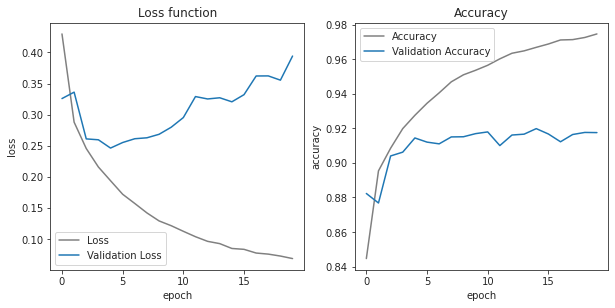

=== Classification Report ===

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.90      0.85      0.88      1000
       Dress       0.90      0.93      0.92      1000
        Coat       0.85      0.90      0.87      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.77      0.75      0.76      1000
     Sneaker       0.98      0.95      0.96      1000
         Bag       0.98      0.98      0.98      1000
        Boot       0.96      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



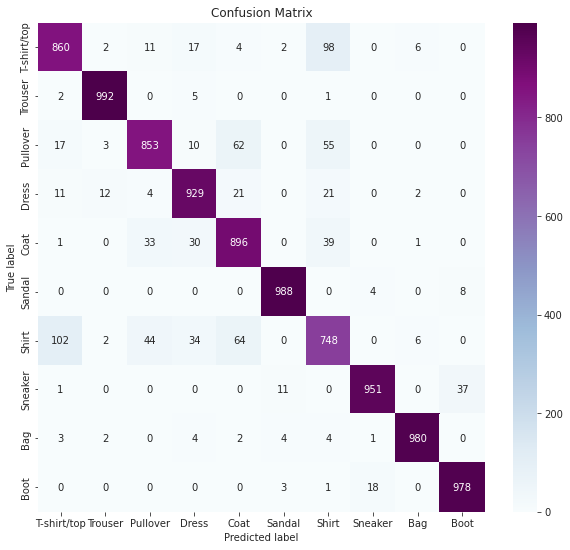

The shape of the conv2d_174 is =======>> (1, 28, 28, 32)
The shape of the max_pooling2d_82 is =======>> (1, 14, 14, 32)
The shape of the conv2d_175 is =======>> (1, 14, 14, 64)
The shape of the max_pooling2d_83 is =======>> (1, 7, 7, 64)
The shape of the dropout_40 is =======>> (1, 7, 7, 64)
The shape of the flatten_40 is =======>> (1, 3136)
The shape of the dense_87 is =======>> (1, 50)
The shape of the dense_88 is =======>> (1, 10)
(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 14, 14, 64)
(1, 7, 7, 64)
(1, 7, 7, 64)
(1, 3136)
(1, 50)
(1, 10)


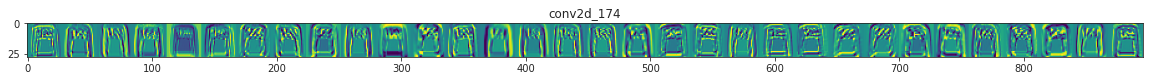

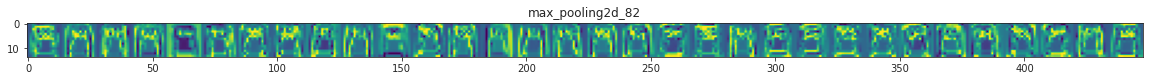

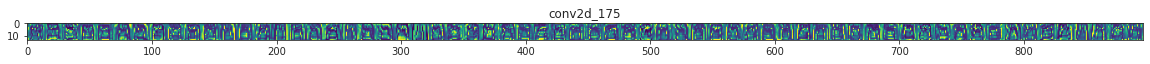

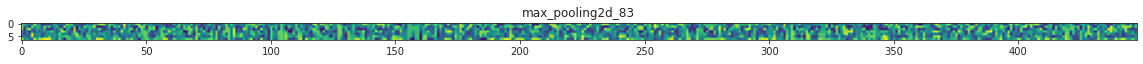

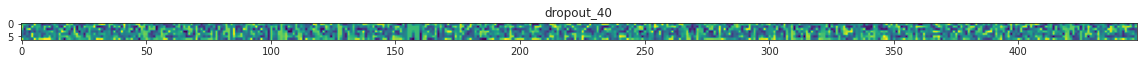

In [26]:
# Now we fit the model with 20 epochs and early stopping using the best hyperparameters above

# Start timer
start = timeit.default_timer()

# Build the model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='tanh',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='tanh',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Specify the optimiser
opt = keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Define a callback to monitor validation accuracy with early stopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 5)

# Save the best model
model_checkpoint = ModelCheckpoint('bestmodel.hdf5', save_best_only = True)

# Fit the model
h_callback = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=32, verbose=2,
                       callbacks=[monitor_val_acc,model_checkpoint]
                       )



# Stop timer
stop = timeit.default_timer()

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)



# Specify variables
y_pred = model.predict(X_test)
target_names = label_map.values()

# Model evaluation

print("===============================================")
# Print model summary
model.summary()
cnn5_acc = scores[1]*100
cnn5_runtime = stop - start
print("CNN5 Accuracy: %.2f%%" % cnn5_acc)
print('Training time (s): ', cnn5_runtime)

# Print evaluation report
loss_acc_plots(h_callback)
classification_summary(y_pred,y_test, target_names)

# Print feature maps
input = X_test[1].reshape(1,28,28,1)
plot_featuremap(model, input)

# 6 Evaluation



## 6.1 Model performance
Model selection would depend on the business case. We plot the accuracy and runtimes of the models to compare performance.
1.   For quick deployment, CNN5 is preferred. CNN5's accuracy was better than ResNet50 and almost 10 times faster.
2.   If timing were not an issue, Inception V3 is preferred for its high accuracy.

In [25]:
# Compile performance indicators
performance = {'model':['ResNet50','Inception-v3','CNN1','CNN2','CNN3','CNN4','CNN5'],
               'accuracy': [resnet50_acc, inceptionv3_acc, cnn1_acc, cnn2_acc, cnn3_acc, cnn4_acc, cnn5_acc], 
               'runtime': [resnet50_runtime, inceptionv3_runtime, cnn1_runtime, cnn2_runtime, cnn3_runtime, cnn4_runtime, cnn5_runtime],
        
       }

# Make df 
df_performance = pd.DataFrame(performance)

# Plot accuracy against runtime
import plotly.express as px
fig = px.scatter(df_performance, x='runtime', y='accuracy',hover_data=['model'],
                 title="Model performance")
fig.show()

## 6.2 Investigating errors

1. From the confusion matrices, we observe that all models, including ResNet50 and Inception v3, **tend to misclassify Tshirts/tops, shirts, and coats**. This is likely because these clothing items are similar in form.
2. We visualise the incorrect predictions of CNN5 by plotting them below. Some of these look ambiguous to the human eye too.

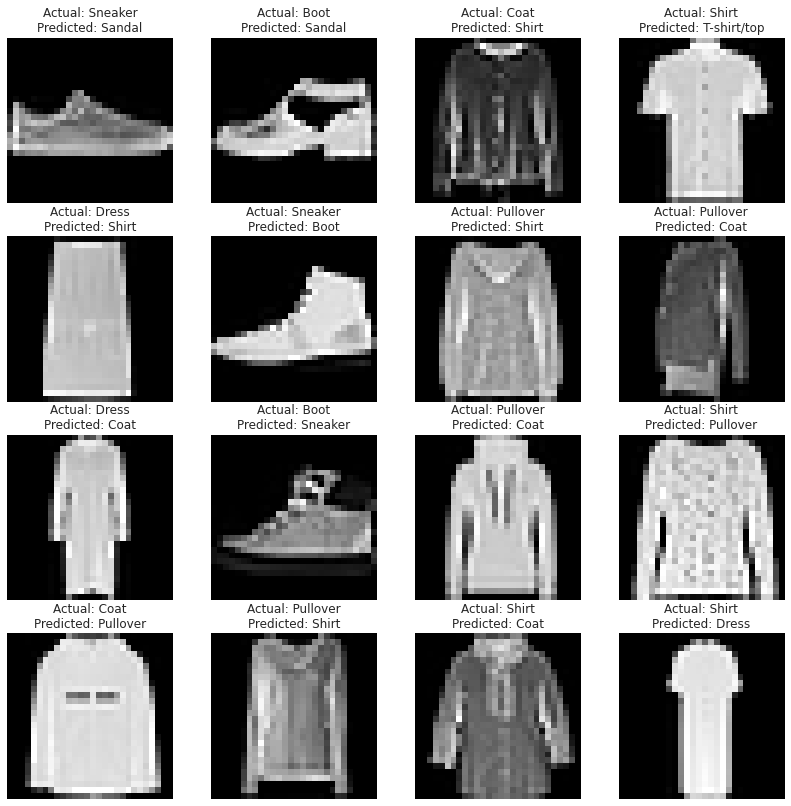

In [27]:
# Plot the incorrect predictions of CNN5

# Get the numerical label of y_pred
y_pred_array = np.argmax(y_pred, axis=1)
# Convert to text labels
y_pred_labels = [*map(label_map.get, y_pred_array)]

# Get the numerical label of y_test
y_test_array = np.argmax(y_test, axis=1)

# Create boolean mask
mask = (y_pred_array!=y_test_array)
incorrect = y_test_array[mask]


# Define function to plot images in grid
def plot_comparison_grid(data, grid_l, grid_h):
  samples = grid_l*grid_h

  # Plot the grid
  plt.figure(figsize=(grid_l*3.5, grid_h*3.5))
  for i in range(samples):
    plt.subplot(grid_h,grid_l,i+1)
    plt.imshow(data[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.axis('off')

    #Set labels
    y_pred_incorrect_labels = [*map(label_map.get, y_pred_array[mask])]
    y_test_incorrect_labels = [*map(label_map.get, y_test_array[mask])]
    plt.title("Actual: {}".format(y_test_incorrect_labels[i])+"\n"+"Predicted: {}".format(y_pred_incorrect_labels[i]))
  plt.show()


# Set number of plots
data = X_test[mask]
grid_l = 4
grid_h = 4

plot_comparison_grid(data, grid_l, grid_h)

## 6.3 A closer look at CNN5's feature maps

CNN5’s layers generate recognizable feature maps of the item’s outline, down to the dropout layer. To recall, our first bespoke CNN model’s feature maps were unrecognizable from the 3rd layer. In this aspect, the layers in CNN5 are more “explainable” than CNN1.

The shape of the conv2d_174 is =======>> (1, 28, 28, 32)
The shape of the max_pooling2d_82 is =======>> (1, 14, 14, 32)
The shape of the conv2d_175 is =======>> (1, 14, 14, 64)
The shape of the max_pooling2d_83 is =======>> (1, 7, 7, 64)
The shape of the dropout_40 is =======>> (1, 7, 7, 64)
The shape of the flatten_40 is =======>> (1, 3136)
The shape of the dense_87 is =======>> (1, 50)
The shape of the dense_88 is =======>> (1, 10)
(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 14, 14, 64)
(1, 7, 7, 64)
(1, 7, 7, 64)
(1, 3136)
(1, 50)
(1, 10)


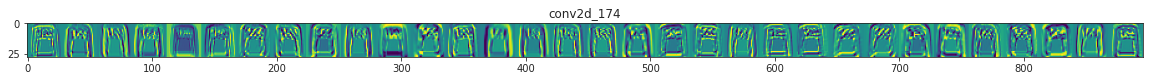

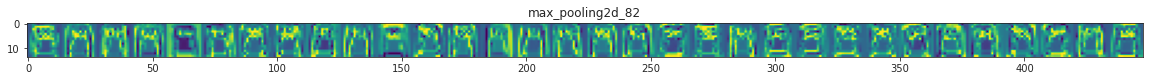

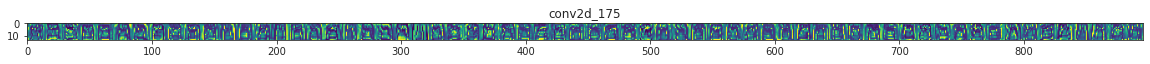

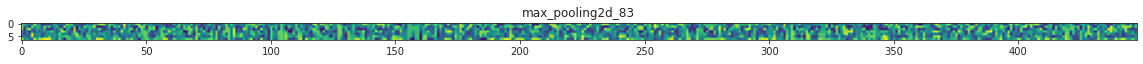

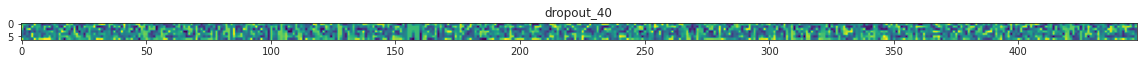

In [28]:
# Print feature maps of CNN5
input = X_test[1].reshape(1,28,28,1)
plot_featuremap(model, input)

# 7 Conclusion
The task was to classify items in the Fashion MNIST dataset using deep learning methods.

We used pre-trained models such as ResNet50 and Inception V3 as the “gold standard”. 

We explored bespoke CNN models, experimenting with different architectures and hyperparameter tuning. Architectural changes impacted accuracy the most. In our case, hyperparameter tuning was time-consuming and improved the accuracy only marginally. Two of our bespoke models, CNN4 and CNN5 outperformed ResNet50.

Model selection would depend on the business case.
*   **For quick deployment, CNN5 is preferred**. CNN5's accuracy was better than ResNet50 and almost 10 times faster.
*   If timing were not an issue, Inception V3 is preferred for its high accuracy.
